First, let's create the moon dataset

In [1]:
from sklearn.datasets import make_moons

m = 1000
X_moons, y_moons = make_moons(m, noise=0.1, random_state=42)

Let's take a peek at the dataset

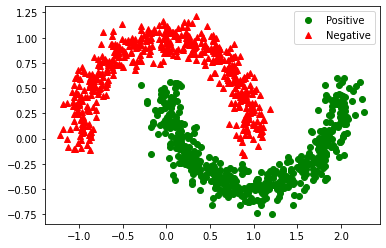

In [2]:
import matplotlib.pyplot as plt

plt.plot(X_moons[y_moons == 1, 0], X_moons[y_moons == 1, 1], 'go', label="Positive")
plt.plot(X_moons[y_moons == 0, 0], X_moons[y_moons == 0, 1], "r^", label="Negative")
plt.legend()
plt.show()

We must not forget to add an extra bias feature ($x_0=1$) to every instance

In [3]:
import numpy as np
X_moons_with_bias = np.c_[np.ones((m, 1)), X_moons]

Let's reshape `y_train` to make it a column vector (i.e. a 2D array with a single column)

In [4]:
y_moons_column_vector = y_moons.reshape(-1, 1)
y_moons_column_vector.shape

(1000, 1)

Now let's split the data into a training set and a test set

In [5]:
test_ratio = 0.2
test_size = int(m * test_ratio)
X_train = X_moons_with_bias[:-test_size]
X_test = X_moons_with_bias[-test_size:]
y_train = y_moons_column_vector[:-test_size]
y_test = y_moons_column_vector[-test_size:]

Now let's create a small function to generate training batches. 

In [6]:
def random_batch(X_train, y_train, batch_size):
    rnd_indices = np.random.randint(0, len(X_train), batch_size)
    X_batch = X_train[rnd_indices]
    y_batch = y_train[rnd_indices]
    return X_batch, y_batch

Let's look at a small batch

In [7]:
X_batch, y_batch = random_batch(X_train, y_train, 5)
print(X_batch)
print(y_batch)

[[ 1.          0.73699957  0.35492668]
 [ 1.          0.32614229  0.91241157]
 [ 1.          1.87285957  0.00337095]
 [ 1.         -0.36542964  0.93849161]
 [ 1.          1.85213647 -0.01441108]]
[[0]
 [0]
 [1]
 [0]
 [1]]


Now let's build the model. Logistic Regression model first computes a weighted sum of the inputs (just like the Linear Gregression model), and then it applies the sigmoid function to the result, which gives us the estimated probability for the positive class:

$$
\hat{p}=h_\theta(\mathbf{x})=\sigma(\theta^T\mathbf{x})
$$

SInce we want to be able to make predictions for multiple instances at a time, we will use an input matrix $\mathbf{X}$ rather than a single input vector. The $i^{th}$ row will contain the transpose of the $i^{th}$ input vector $(\mathbf{x}^{(i)})^T$. It is then possible to estimate the probability that each instance belongs to the positives class using the following equation:

$$
\hat{\mathbf{p}}=\sigma(\mathbf{X}\theta)
$$

In [8]:
import tensorflow as tf

# the moons dataset has two input features, since each instance is a point on a plane.
n_inputs = 2

X = tf.placeholder(tf.float32, shape=(None, n_inputs + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
theta = tf.Variable(tf.random_uniform([n_inputs + 1, 1], -1.0, 1.0, seed=42), name="theta")
logits = tf.matmul(X, theta, name="logits")
# 1 / ( 1 + tf.exp(-logits))
y_proba = tf.sigmoid(logits)

D:\program_files\python3.6.6\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\program_files\python3.6.6\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\program_files\python3.6.6\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\program_files\python3.6.6\lib\site-packages\tensorflow\python\framework\dtypes.py:526: Futu

As we saw in chapter 4, the log loss is a good cost function to use for Logistic Regression:

$$
J(\theta)=-\frac{1}{m}\sum_{i=1}^m[y^{(i)}\log (p^{(i)})+(1-y^{(i)})\log (1-\hat{p}^{(i)})]
$$

One option is to implement it ourselves:

In [ ]:
epsilon = 1e-7  # to avoid an overflow when computing the log
loss = -tf.reduce_mean(y * tf.log(y_proba + epsilon) + (1 - y) * tf.log(1-y_proba + epsilon))

But we might as well use TensorFlow's `tf.losses.log_loss()` function

In [9]:
loss = tf.losses.log_loss(y, y_proba)  # uses epsilon = 1e-7 by default

Let's create the optimizer and tell it to minimize the cost function

In [10]:
learning_rate = 0.01
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

Let's train the model

In [13]:
init = tf.global_variables_initializer()

n_epochs = 1000
batch_size = 50
n_batches = m // batch_size

with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = random_batch(X_train, y_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            
        loss_val = loss.eval({X: X_test, y: y_test})
        if epoch % 100 == 0:
            print("Epoch: ", epoch, "\tLoss: ", loss_val)
            
    y_proba_val = y_proba.eval(feed_dict={X: X_test, y: y_test})

Epoch:  0 	Loss:  0.87722933
Epoch:  100 	Loss:  0.35173324
Epoch:  200 	Loss:  0.31150284
Epoch:  300 	Loss:  0.2948495
Epoch:  400 	Loss:  0.28620338
Epoch:  500 	Loss:  0.28146827
Epoch:  600 	Loss:  0.27846852
Epoch:  700 	Loss:  0.2765891
Epoch:  800 	Loss:  0.27556154
Epoch:  900 	Loss:  0.27457917


For each instance in the test set, `y_proba_val` contains the estimated probability that it belongs to the positive class, according to the model. For example, here are the first 5 estimated probabilities:

In [14]:
y_proba_val[:5]

array([[0.5436219 ],
       [0.7080068 ],
       [0.5133462 ],
       [0.99097097],
       [0.506245  ]], dtype=float32)

To classify each instance, we can go for maximum likelihood: classify as positive any instance whose estimated probability is greater or equal to 0.5:

In [15]:
y_pred = (y_proba_val >= 0.5)
y_pred[:5]

array([[ True],
       [ True],
       [ True],
       [ True],
       [ True]])

Depending on the use case, you may want to choose a different threshold than 0.5: make it higher if you want high precision (but lower recall), and make it lower if you want high recall (but lower precision).

In [17]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))

0.8613861386138614
0.8787878787878788


Let's plot these predictions to see what they look like:

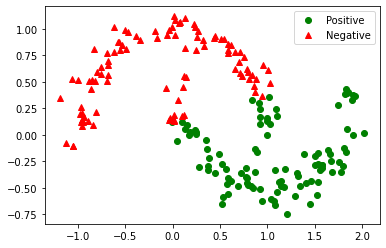

In [18]:
y_pred_idx = y_pred.reshape(-1)
plt.plot(X_test[y_pred_idx, 1], X_test[y_pred_idx, 2], 'go', label="Positive")
plt.plot(X_test[~y_pred_idx, 1], X_test[~y_pred_idx, 2], 'r^', label="Negative")
plt.legend()
plt.show()

Logistic Regreession model has a linear decision boundary, so this is actually close to the best we can do with this model.

Now let's start over, but this time we will add all the bells and whistles, as listed in the exercise:
- Define the graph within a `logistic_regression()` function that can be reused easily.
- Save checkpoints using a `Saver` at regular intervals during training, and save the final model at the end of training.
- Restore the last checkpoint upon startup if training was interrupted.
- Define the graph using nice scopes so the graph looks good in TensorBoard
- Add summaries to visualize the learning curves in TensorBoard
- Try tweaking some hyperparameters such as the learning rate or the mini-batch size and look at the shape of the learning curve.

Before we start, we will add 4 more features to the inputs: $x_1^2,x_2^2,x_1^3$ and $x_2^3$. You can also add them using `sklearn.preprocessing.PolynomialFeature`

In [32]:
X_train_enhanced = np.c_[X_train,
                        np.square(X_train[:, 1]),
                        np.square(X_train[:, 2]),
                        X_train[:, 1] ** 3,
                        X_train[:, 2] ** 3]

X_test_enhanced = np.c_[X_test,
                        np.square(X_test[:, 1]),
                        np.square(X_test[:, 2]),
                        X_test[:, 1] ** 3,
                        X_test[:, 2] ** 3]

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
reset_graph()

Now let's define the `logistic_regression()` function to create the graph.

In [22]:
def logistic_regression(X, y, initializer=None, seed=42, learning_rate=0.01):
    n_inputs_including_bias = int(X.get_shape()[1])
    with tf.name_scope("logistic_regression"):
        with tf.name_scope("model"):
            if initializer is None:
                initializer = tf.random_uniform([n_inputs_including_bias, 1], -1.0, 1.0, seed=seed)
            theta = tf.Variable(initializer, name="theta")
            logits = tf.matmul(X, theta, name="logits")
            y_proba = tf.sigmoid(logits)
            
        with tf.name_scope("train"):
            loss = tf.losses.log_loss(y, y_proba, scope="loss")
            optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
            training_op = optimizer.minimize(loss)
            loss_summary = tf.summary.scalar("log_loss", loss)
            
        with tf.name_scope("init"):
            init = tf.global_variables_initializer()
            
        with tf.name_scope("save"):
            saver = tf.train.Saver()
            
    return y_proba, loss, training_op, loss_summary, init, saver

Let's create a little function to get the name of the log directory to save the summaries for TensorBoard

In [23]:
from datetime import datetime

def log_dir(prefix=""):
    now = datetime.now().strftime("%Y%m%d%H%M%S")
    root_logdir = 'tf_logs'
    if prefix:
        prefix += "-"
        
    name = prefix + "run-" + now
    return "{}/{}/".format(root_logdir, name)

Next, let's create the graph, using the `logistic_regression()` function. We will also create the `FileWriter` to save the summaries to the log directory for TensorBoard:

In [41]:
reset_graph()

n_inputs = 2 + 4
logdir = log_dir("logreg")

X = tf.placeholder(tf.float32, shape=(None, n_inputs+1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

y_proba, loss, training_op, loss_summary, init, saver = logistic_regression(X, y)

file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

At last we can train the model. We will start by checking whether a previous training session was interrupted, and if so we will load the checkpoint and continue training from the epoch number we saved.

In [42]:
import os

n_epochs = 10001
batch_size = 50
n_batches = m // batch_size

checkpoint_path = 'tmp/my_logreg_model.ckpt'
checkpoint_epoch_path = checkpoint_path + ".epoch"
final_model_path = "./my_logreg_model"

with tf.Session() as sess:
    if os.path.isfile(checkpoint_epoch_path):
        # if the checkpoint file exists, restore the model and load the epoch number
        with open(checkpoint_epoch_path, "rb") as f:
            start_epoch = int(f.read())
            
        print("Training was interrupted, Continuing at epoch", start_epoch)
        saver.restore(sess, checkpoint_path)
    else:
        start_epoch = 0
        sess.run(init)
    
    print('Start epoch: {}'.format(start_epoch))
    for epoch in range(start_epoch, n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = random_batch(X_train_enhanced, y_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            
        loss_val, summary_str = sess.run([loss, loss_summary], feed_dict={X: X_test_enhanced, y: y_test})
        file_writer.add_summary(summary_str, epoch)
        if epoch % 500 == 0:
            print("Epoch: ", epoch, "\tLoss: ", loss_val)
            saver.save(sess, checkpoint_path)
            with open(checkpoint_epoch_path, 'wb') as f:
                f.write(b"%d" % (epoch + 1))
    
    saver.save(sess, final_model_path)
    y_proba_val = y_proba.eval(feed_dict={X: X_test_enhanced, y: y_test})
    os.remove(checkpoint_epoch_path)

Start epoch: 0
Epoch:  0 	Loss:  0.629985
Epoch:  500 	Loss:  0.16122366
Epoch:  1000 	Loss:  0.11903212
Epoch:  1500 	Loss:  0.097329214
Epoch:  2000 	Loss:  0.083697945
Epoch:  2500 	Loss:  0.07437584
Epoch:  3000 	Loss:  0.067502156
Epoch:  3500 	Loss:  0.062206898
Epoch:  4000 	Loss:  0.05802679
Epoch:  4500 	Loss:  0.05456298
Epoch:  5000 	Loss:  0.051708285
Epoch:  5500 	Loss:  0.04923774
Epoch:  6000 	Loss:  0.047167283
Epoch:  6500 	Loss:  0.045376644
Epoch:  7000 	Loss:  0.04381875
Epoch:  7500 	Loss:  0.04237422
Epoch:  8000 	Loss:  0.041089162
Epoch:  8500 	Loss:  0.03997092
Epoch:  9000 	Loss:  0.038920246
Epoch:  9500 	Loss:  0.038010746
Epoch:  10000 	Loss:  0.03715569


Once again, we can make predictions by just classifying as positive all the instances whose estiamted probability is greater or equal to 0.5

In [43]:
from sklearn.metrics import precision_score, recall_score

y_pred = (y_proba_val >= 0.5)
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))

0.9797979797979798
0.9797979797979798


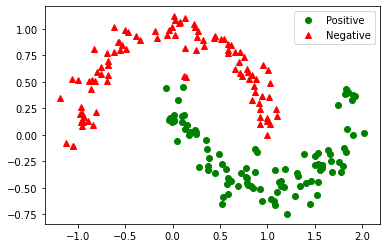

In [45]:
y_pred_idx = y_pred.reshape(-1)
plt.plot(X_test[y_pred_idx, 1], X_test[y_pred_idx, 2], "go", label="Positive")
plt.plot(X_test[~y_pred_idx, 1], X_test[~y_pred_idx, 2], 'r^', label="Negative")
plt.legend()
plt.show()

Now that's much better! Apparently the new features really helped a lot.

Try starting the tensorboard server, find the latest run and look at the learning curve.

In [ ]:
tensorboard --logidr=tf_logs